In [1]:
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import gym_bart
import itertools
from umap import UMAP
from plotting_utils import (
    set_rc, 
    add_abc_to_subaxes, 
    colors, 
    rgb_colors
)
from model_evaluation import (
    forced_action_evaluate, 
    meta_bart_callback,
    meta_bart_multi_callback,
    reshape_parallel_evalu_res,
    forced_action_evaluate_multi,
)
from bart_behavior_analysis import (
    plot_1color5fsize,
    plot_1colornfsize
)
from read_experiments import average_runs, load_exp_df
import re

from functools import partial
import sys
sys.path.append('../')
from ppo.envs import make_vec_env
import pickle
from tqdm import tqdm
from collections import defaultdict

from bart_representation_analysis import *
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

set_rc()

In [315]:
size = np.arange(0.2, 1.01, 0.05)
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, s, 0]} for s in size]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=17,
                seed=1,
                deterministic=False,
                with_activations=True)

In [321]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/240.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)

# Visualize flow for single step

In [345]:
postfix = ''
model = 1.2
t = 2
chk = 100
ep = 12

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
decision_nodes = find_decision_nodes(res, model, ep)
delt_actor0, probs = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=decision_nodes,
                                            large_kick=False, ap=True)

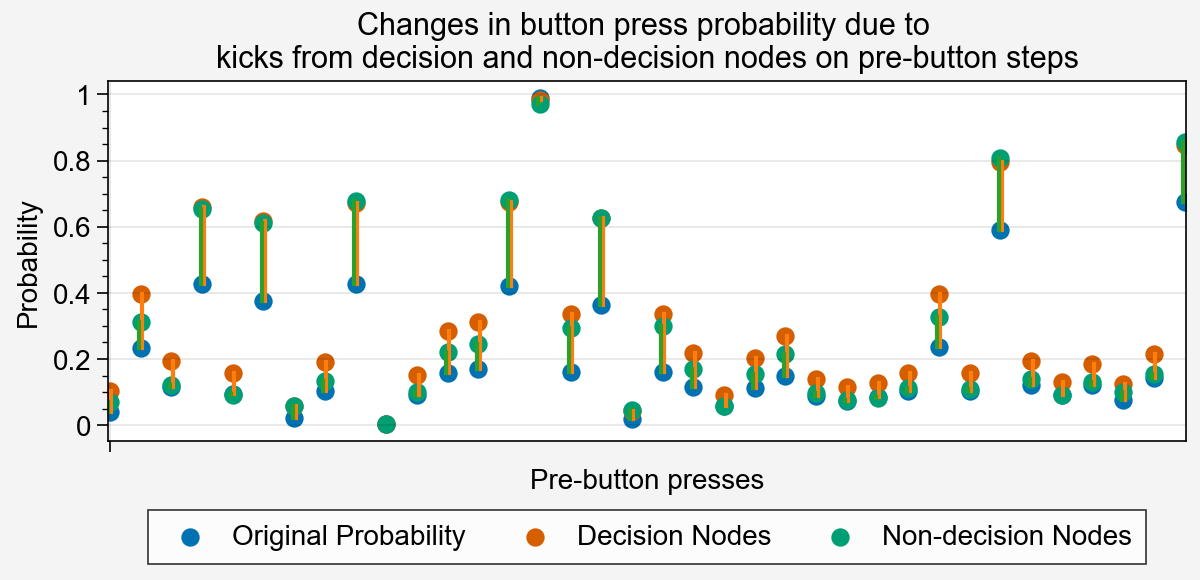

In [283]:
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
true_probs = res['action_probs'][ep][penult_steps, 1]
ax.scatter(true_probs, label='Original Probability')
ax.scatter(probs[:, 0], label='Decision Nodes')
ax.scatter(probs[:, 1], label='Non-decision Nodes')
for i in range(len(true_probs)):
    ax.plot([i+0.05, i+0.05], [true_probs[i], probs[i, 0]], c=rgb_colors[1])
    ax.plot([i-0.05, i-0.05], [true_probs[i], probs[i, 1]], c=rgb_colors[2])
    
ax.legend(loc='b')
ax.format(xlabel='Pre-button presses', xlocator=range(1), xformatter=[''],
          ylabel='Probability', 
          title='Changes in button press probability due to \nkicks from decision and non-decision nodes on pre-button steps')

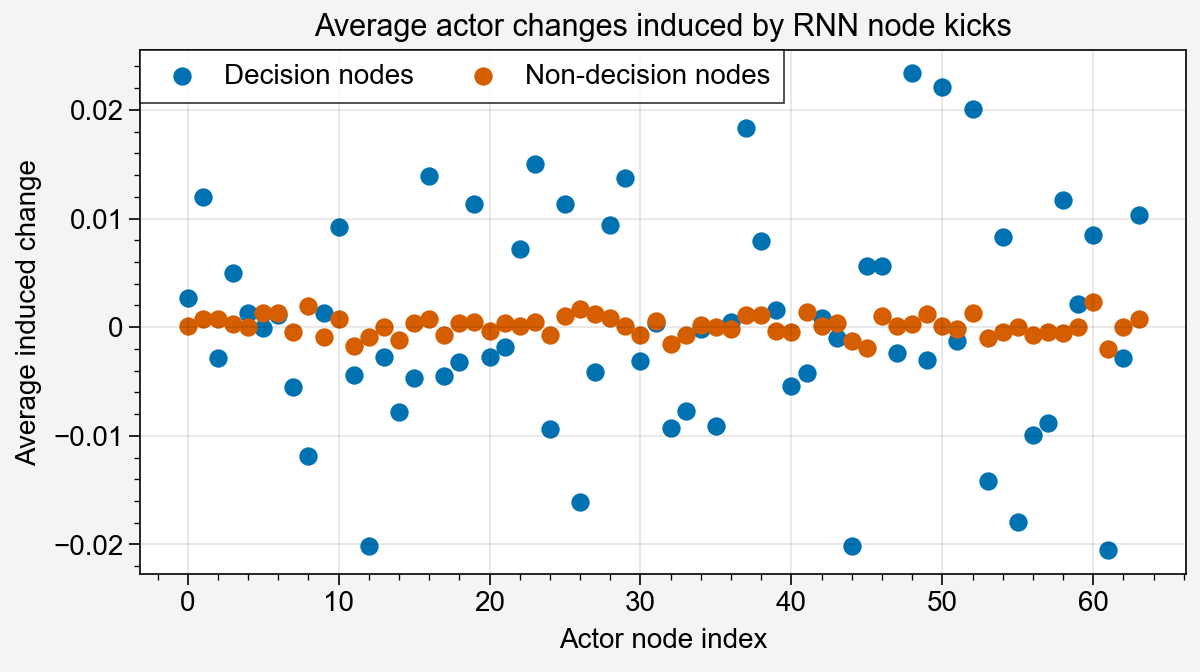

In [296]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

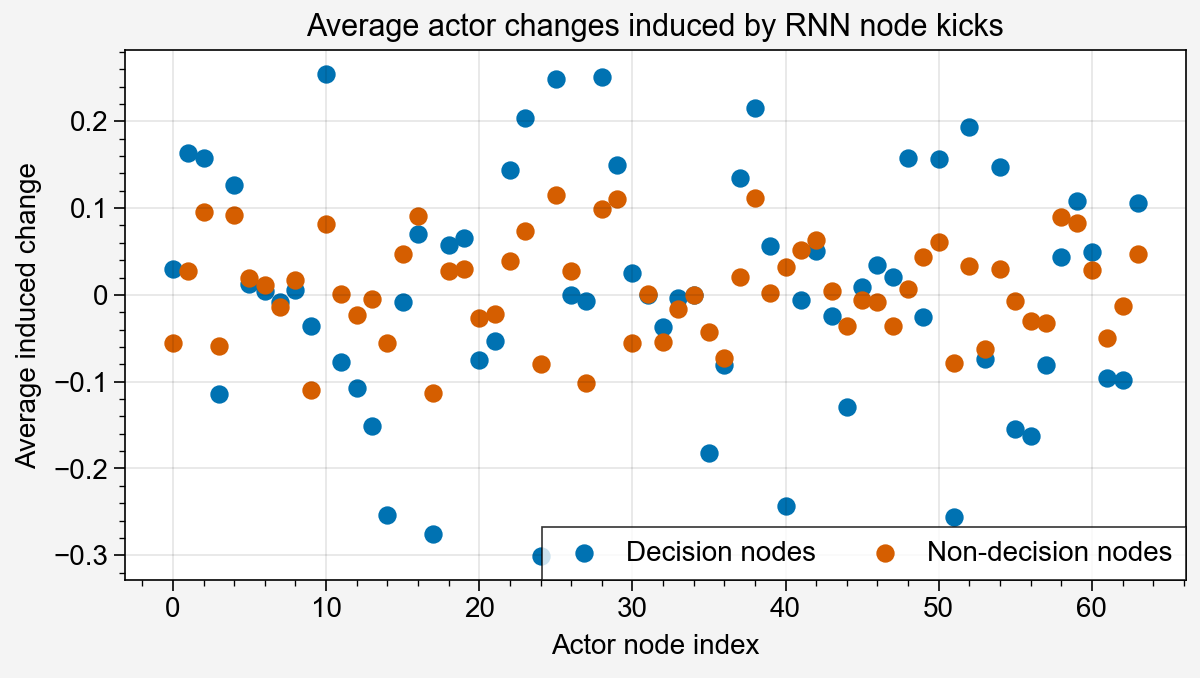

In [346]:
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0], label='Decision nodes')
ax.scatter(delt_actor0[step_idx, 1], label='Non-decision nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by RNN node kicks')
ax.legend()

### Perform for random 6 nodes for comparison to decision nodes

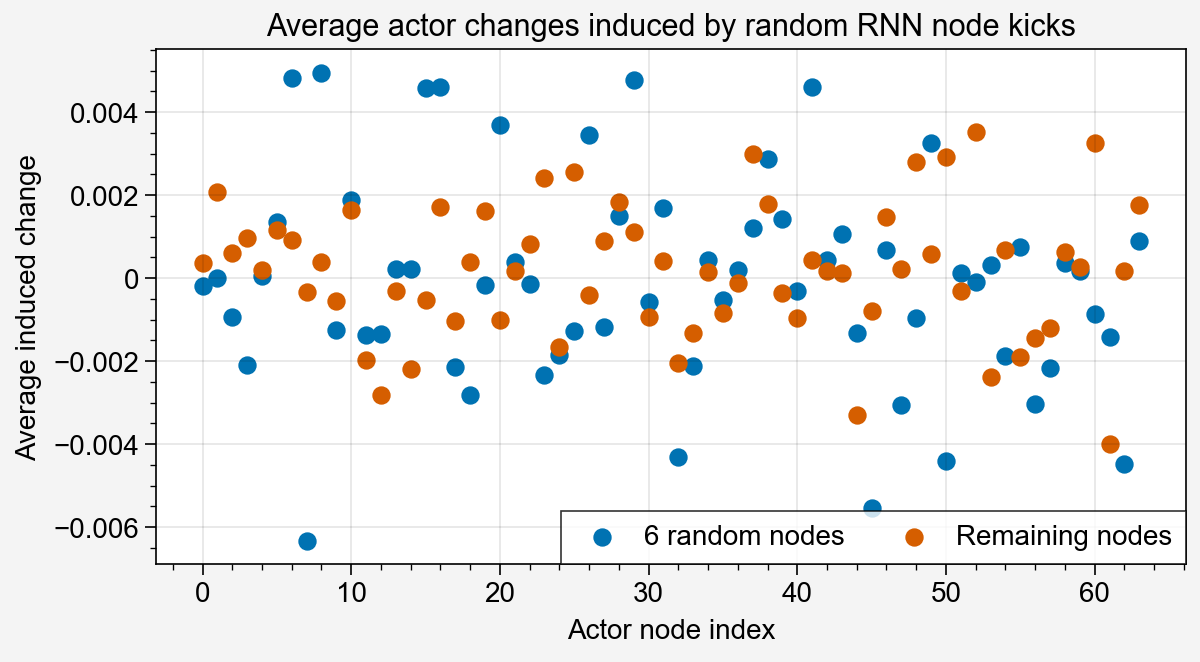

In [304]:
postfix = ''
model = 1.2
t = 2
chk = 100
ep = 12

exp_name = f"p{model}n50{postfix}"
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
presses = np.argwhere((res['actions'][ep] == 1).reshape(-1)).reshape(-1)
ends = np.array(res['data']['balloon_step'][ep])
end_presses = np.intersect1d(presses, ends)
penult_steps = end_presses - 1
# decision_nodes = find_decision_nodes(res, model, ep)
random_nodes = np.full(64, False)
random_nodes[np.random.choice(np.arange(64), (6,))] = True
delt_actor0, probs = measure_rnn_influence_multi(res, model, ep, penult_steps,
                                            decision_nodes=random_nodes,
                                            large_kick=False, ap=True)
fig, ax = pplt.subplots(refaspect=2, figwidth=6)
step_idx = 10
step = penult_steps[step_idx]

actor0 = res['activations']['actor0'][ep][step]
# ax.scatter(actor0)
ax.scatter(delt_actor0[step_idx, 0] / decision_nodes.sum(), label='6 random nodes')
ax.scatter(delt_actor0[step_idx, 1] / (~decision_nodes).sum(), label='Remaining nodes')
ax.format(xlabel='Actor node index', ylabel='Average induced change',
          title='Average actor changes induced by random RNN node kicks')
ax.legend()

# Average decision flows across agents

In [2]:
give_rew = ['', 'giverew_']
postfixes = ['', 'pop0.05', 'pop0.1', 'pop0.2']
models = [1.0, 1.2, 1.5, 1.7, 2.0]
trials = range(3)
chks = np.arange(10, 243, 30)

give_labels = ['Rew not shown', 'Rew shown']
pop_labels = ['0', '-0.05', '-0.1', '-0.2']
pop_vals = [0, -0.05, -0.1, -0.2]
p_labels = ['1.0',' 1.2', '1.5', '1.7', '2.0']
chk_labels = [str(c) for c in chks]
chk_axis = 'Checkpoint'
pop_axis = 'Punishment on pop'
p_axis = 'p'

iterators = [give_rew, postfixes, models, trials, chks]
# iterators = [postfixes, models, trials, chks]
iterators_idxs = [range(len(i)) for i in iterators]
sizes = [len(i) for i in iterators]

res = pickle.load(open('data/meta_representation_results', 'rb'))

def metabart_model_load(h, i, j, k, l):
    give = give_rew[h]
    postfix = postfixes[i]
    model = models[j]
    t = k
    chk = chks[l]
    
    if h == 1 and postfix == '':
        postfix = 'pop0'
    exp_name = f"{give}p{model}n50{postfix}"
    model, (obs_rms, ret_rms) = \
        torch.load(f'../saved_checkpoints/meta_v2/{exp_name}_{t}/{chk}.pt')

    return model, obs_rms

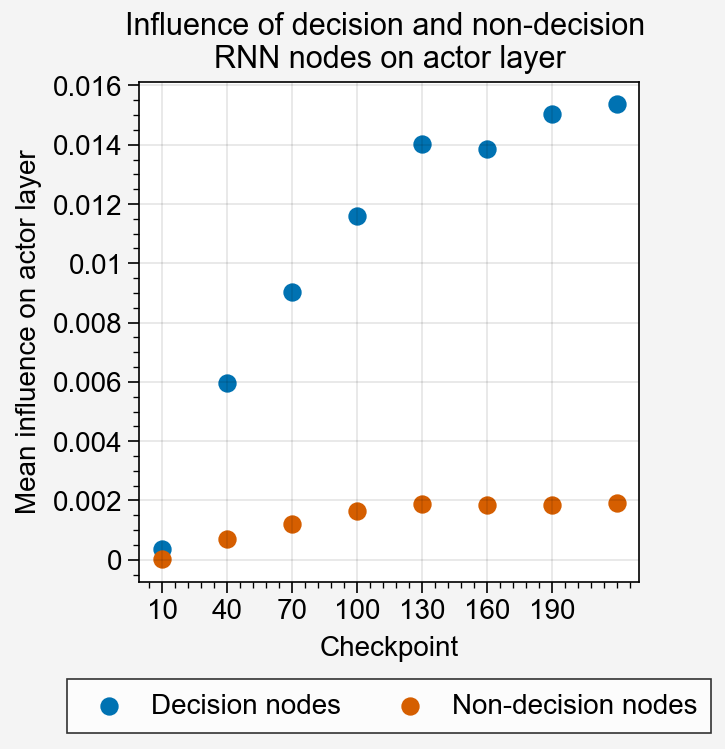

In [15]:
fig, ax = pplt.subplots()
dec_flow_scores = res['dec_flow_scores'][0]
ax.scatter(dec_flow_scores.mean(axis=(0, 1, 2))[:, 0], label='Decision nodes')
ax.scatter(dec_flow_scores.mean(axis=(0, 1, 2))[:, 1], label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(7), xformatter=[str(c) for c in chks],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer')

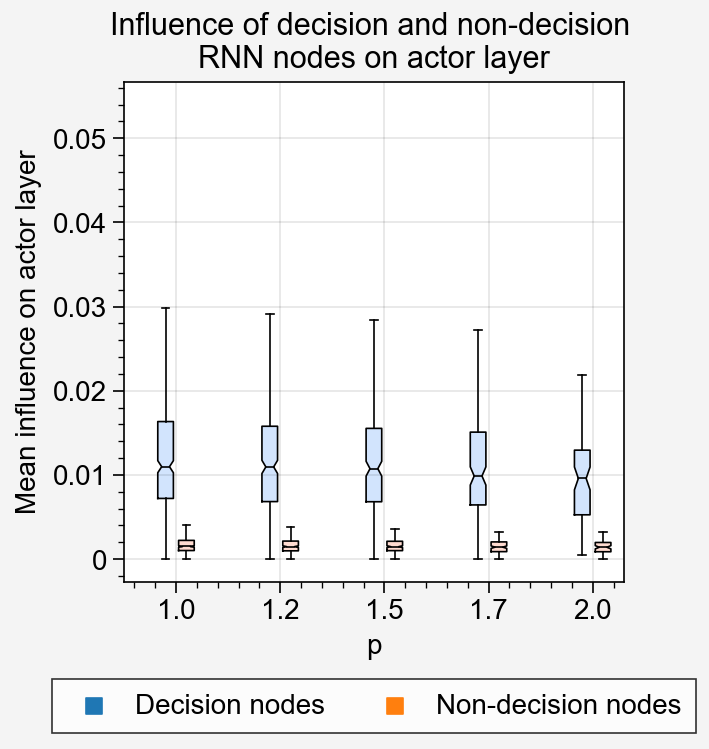

In [20]:
fig, ax = pplt.subplots()
dec_flow_scores = res['dec_flow_scores'][0]
for i in range(len(models)):
    dec = dec_flow_scores[:, i:, :, :, 0].reshape(-1)
    nondec = dec_flow_scores[:, i:, :, :, 1].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 4.4])

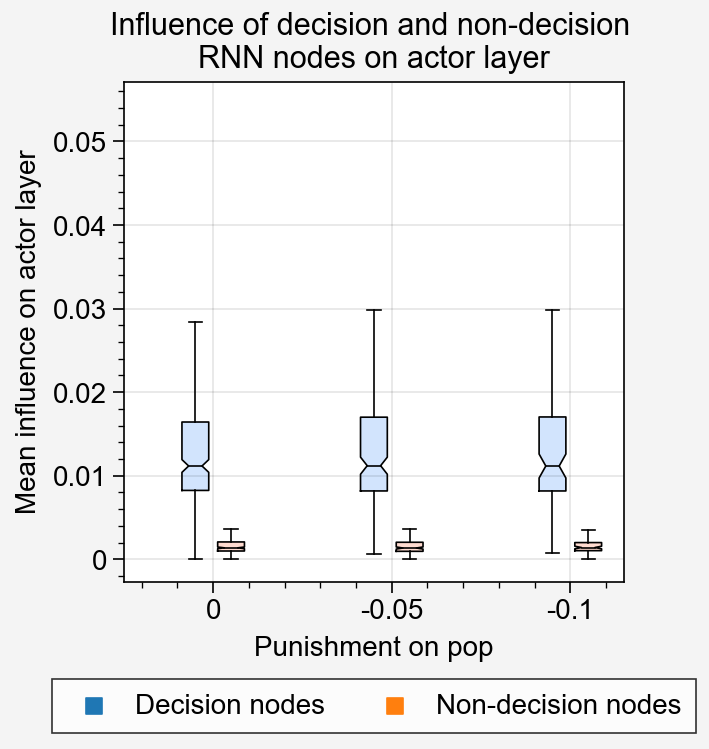

In [231]:
fig, ax = pplt.subplots()
for i in range(len(postfixes)):
    dec = dec_flow_scores[i:, :, :, :, 0].reshape(-1)
    nondec = dec_flow_scores[i:, :, :, :, 1].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, fc=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, fc=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(3)+0.1, xformatter=['0', '-0.05', '-0.1'],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 2.4])

## With give rew in obs

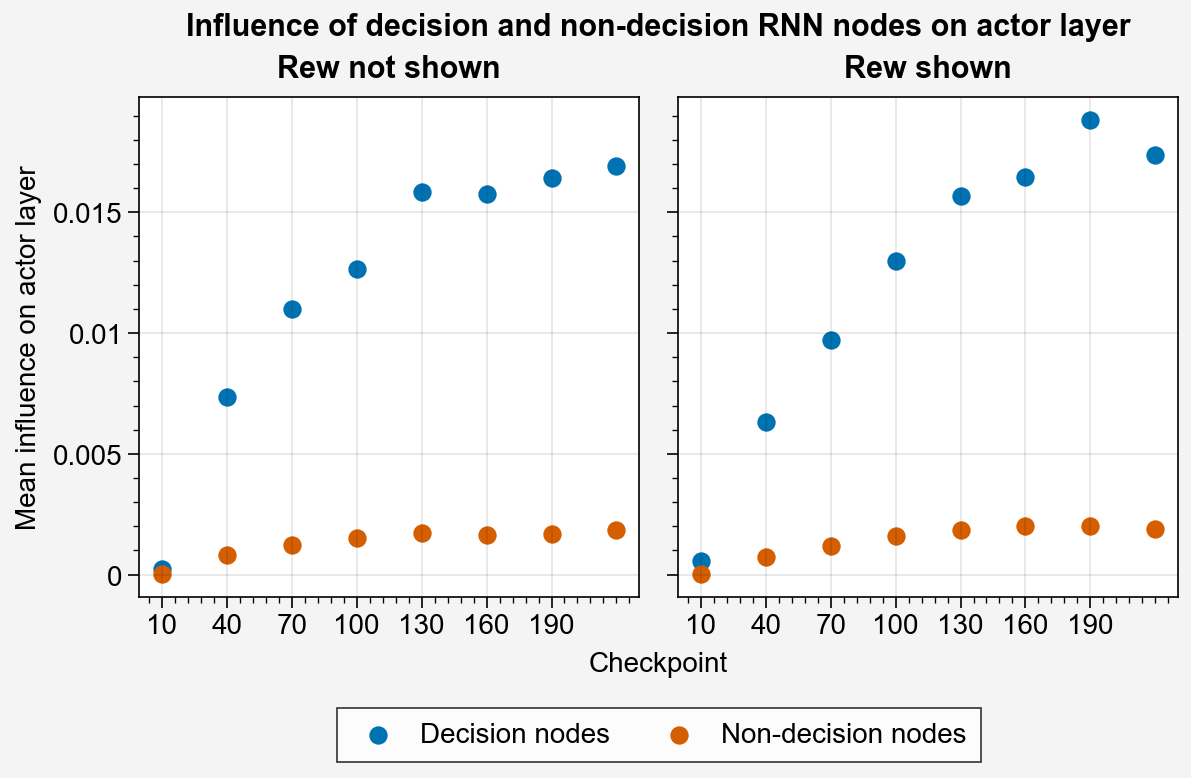

In [12]:
fig, ax = pplt.subplots(ncols=2)

dec_flow_scores = res['dec_flow_scores']
for i in range(2):
    lines = []
    lines.append(ax[i].scatter(dec_flow_scores.mean(axis=(0, 1, 2))[i, :, 0], 
                               label='Decision nodes'))
    lines.append(ax[i].scatter(dec_flow_scores.mean(axis=(0, 1, 2))[i, :, 1], 
                               label='Non-decision nodes'))
fig.legend(lines, loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(7), xformatter=[str(c) for c in chks],
            ylabel='Mean influence on actor layer',
            suptitle='Influence of decision and non-decision RNN nodes on actor layer',
            toplabels=give_labels)

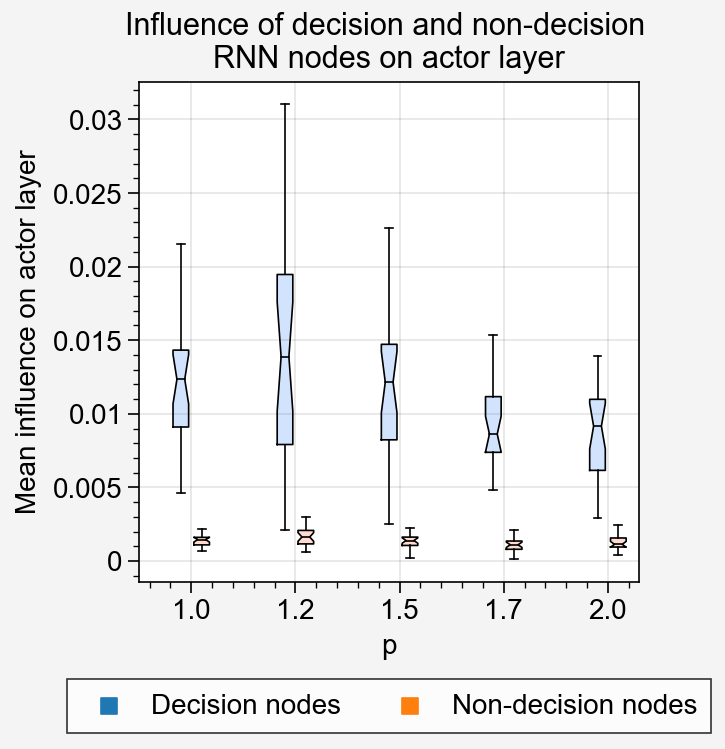

In [21]:
fig, ax = pplt.subplots()
for i in range(len(models)):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0], 'first')
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1], 'first')
    
    dec = dec[:, :, i, :].reshape(-1)
    nondec = nondec[:, :, i, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 4.4])

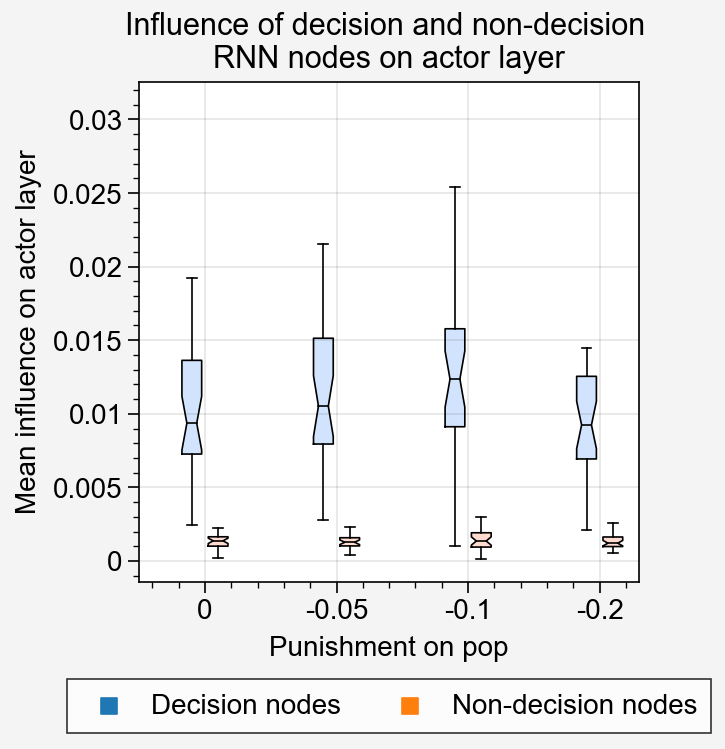

In [20]:
fig, ax = pplt.subplots()
for i in range(4):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0], 'first')
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1], 'first')
    
    dec = dec[:, i, :, :].reshape(-1)
    nondec = nondec[:, i, :, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ax.boxplot([i], dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot([i+0.2], nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlabel=pop_axis, xlocator=np.arange(4)+0.1, xformatter=pop_labels,
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 3.4])

p-value: 0.0742


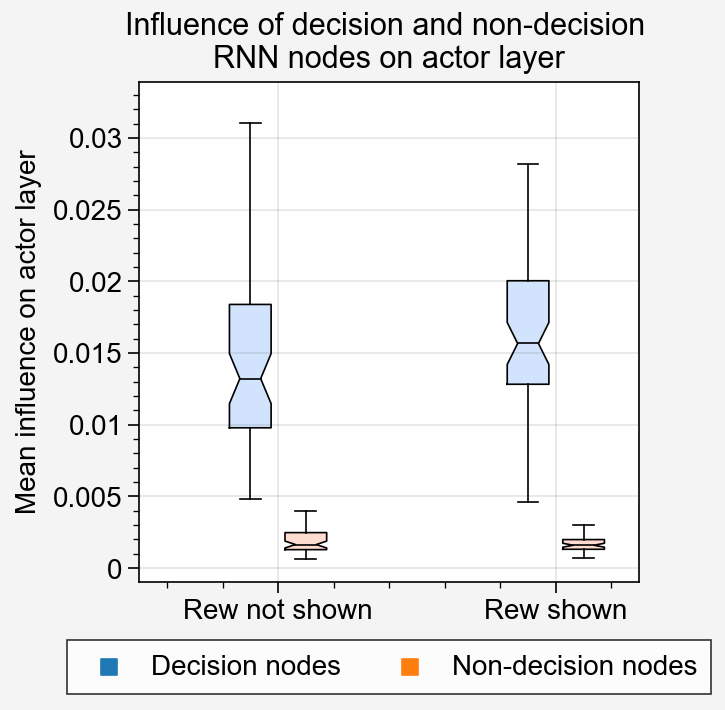

In [19]:
fig, ax = pplt.subplots()
ys = []
for h in range(2):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0])
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1])
    
    dec = dec[h, :, :, :].reshape(-1)
    nondec = nondec[h, :, :, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ys.append(dec)
    ax.boxplot(h, dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot(h+0.2, nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    

print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlocator=np.arange(2)+0.1, xformatter=give_labels,
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer',
            xlim=[-0.4, 1.4])

p-value: 0.7065


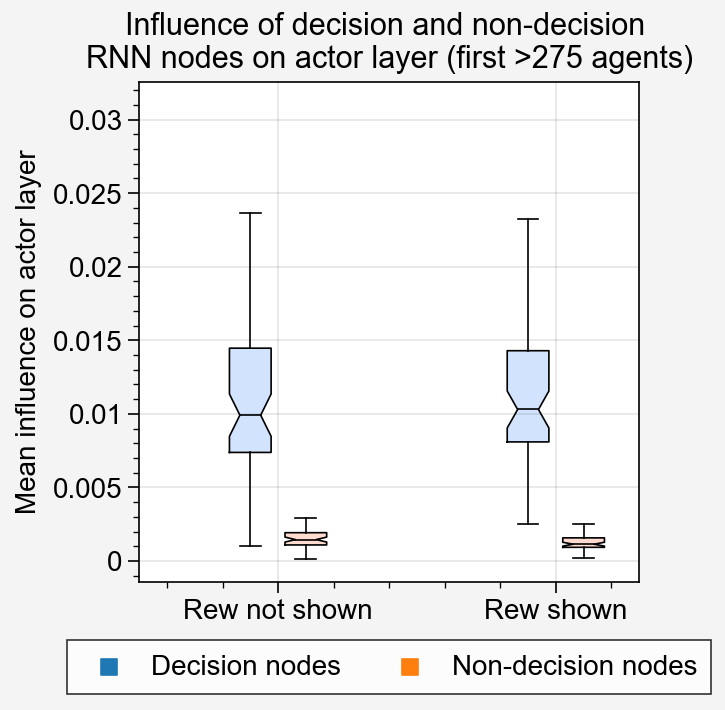

In [19]:
fig, ax = pplt.subplots()
ys = []
for h in range(2):
    dec_flow_scores = res['dec_flow_scores']
    dec = select_idxs(dec_flow_scores[:, :, :, :, :, 0], 'first')
    nondec = select_idxs(dec_flow_scores[:, :, :, :, :, 1], 'first')
    
    dec = dec[h, :, :, :].reshape(-1)
    nondec = nondec[h, :, :, :].reshape(-1)
    dec = dec[dec != 0]
    nondec = nondec[nondec != 0]
    ys.append(dec)
    ax.boxplot(h, dec, notch=True, cycle=rgb_colors[0], fliers=False)
    ax.boxplot(h+0.2, nondec, notch=True, cycle=rgb_colors[1], fliers=False)
    

print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
ax.scatter([-1], [0.01], c=rgb_colors[0], marker='s', label='Decision nodes')
ax.scatter([-1], [0.01], c=rgb_colors[1], marker='s', label='Non-decision nodes')
ax.legend(loc='b')
ax.format(xlocator=np.arange(2)+0.1, xformatter=give_labels,
            ylabel='Mean influence on actor layer',
            title='Influence of decision and non-decision \nRNN nodes on actor layer (first >275 agents)',
            xlim=[-0.4, 1.4])

## Decision node counts

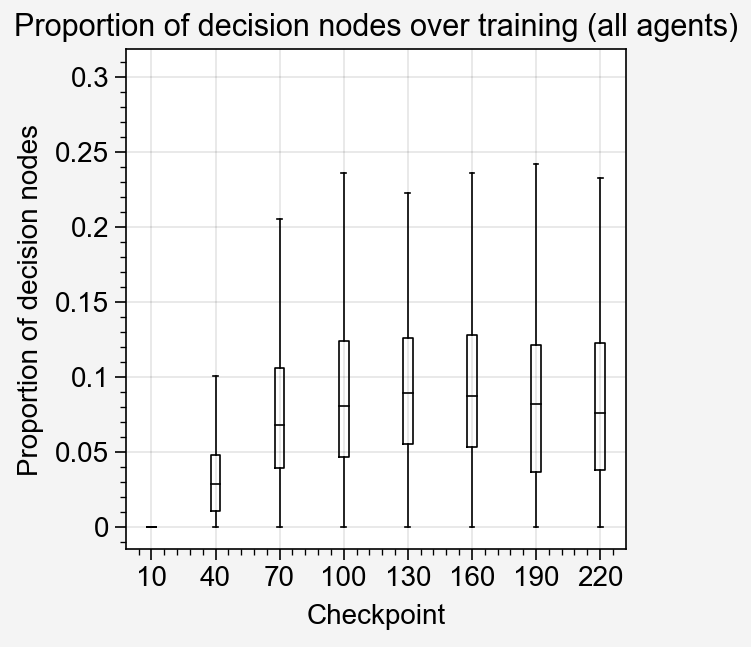

In [8]:
all_decision_nodes = res['all_decision_nodes']
fig, ax = pplt.subplots()
for i in range(len(chks)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=-1).mean(axis=-1)[:, :, :, :, i].reshape(-1) / 64, fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(17), xformatter=[str(c) for c in chks],
            ylabel='Proportion of decision nodes',
            title='Proportion of decision nodes over training (all agents)',
            xlim=[-0.4, 7.4])

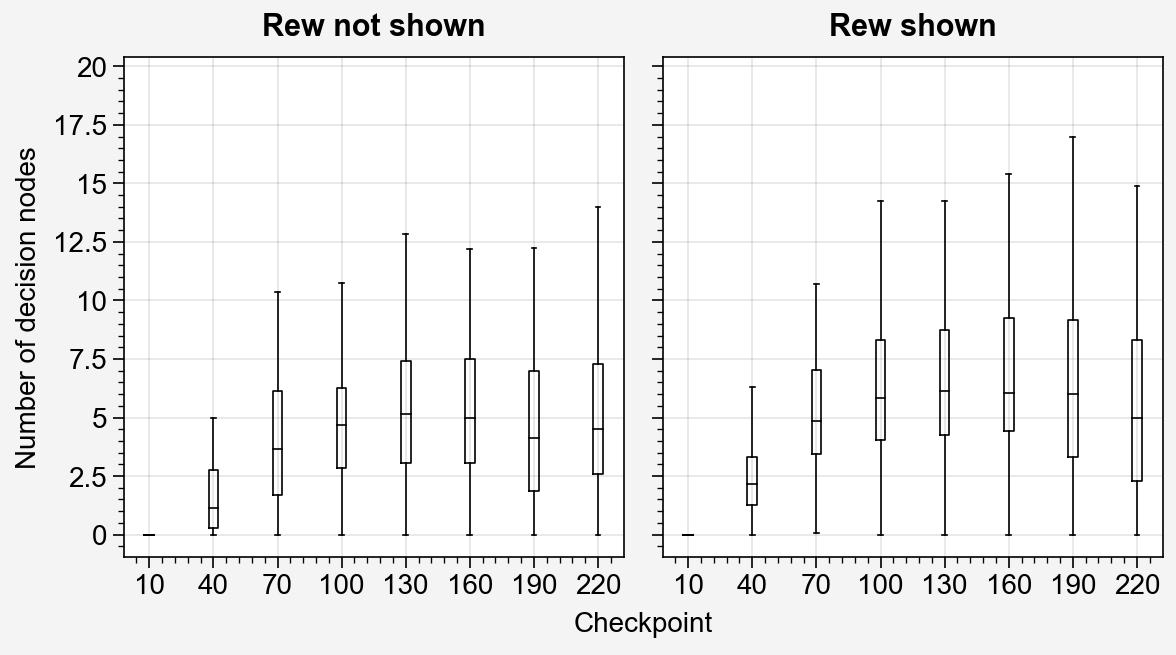

In [23]:
fig, ax = pplt.subplots(ncols=2)
for h in range(2):
    all_decision_nodes = res['all_decision_nodes'][h]
    for i in range(len(chks)):
        # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
        ax[h].boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[:, :, :, i].reshape(-1), fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='Checkpoint', xlocator=range(17), xformatter=[str(c) for c in chks],
            toplabels=give_labels,
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 7.4])

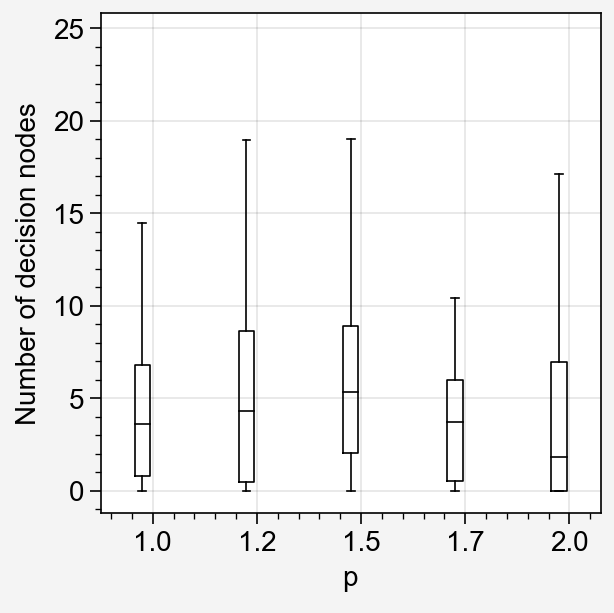

In [342]:
fig, ax = pplt.subplots()
for i in range(len(models)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(0, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[:, i, :, :].reshape(-1), fliers=False)
        
# ax.legend(loc='b')
ax.format(xlabel='$p$', xlocator=np.arange(5)+0.1, xformatter=[str(m) for m in models],
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 4.4])

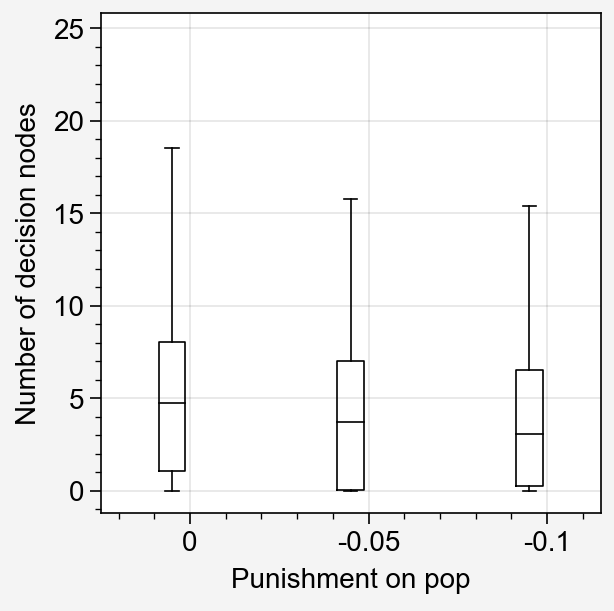

In [343]:
fig, ax = pplt.subplots()
for i in range(len(postfixes)):
    # ax.bar(i, all_decision_nodes.sum(axis=5).mean(axis=(1, 2, 3, 4))[i], c=rgb_colors[0])
    ax.boxplot(i, all_decision_nodes.sum(axis=5).mean(axis=4)[i, :, :, :].reshape(-1), fliers=False)
# ax.legend(loc='b')
ax.format(xlabel='Punishment on pop', xlocator=np.arange(3)+0.1, xformatter=['0', '-0.05', '-0.1'],
            ylabel='Number of decision nodes',
            title='',
            xlim=[-0.4, 2.4])

p-value: 0.7095


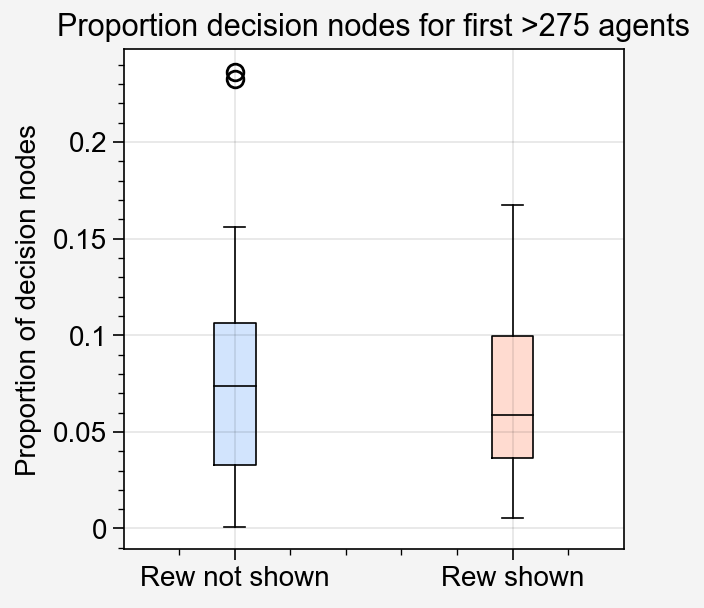

In [16]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')

ys = []
for h in range(2):
    y = all_decision_nodes[h].reshape(-1)
    ys.append(y)
    ax.boxplot(h, y, cycle=rgb_colors[h])
    
print(f'p-value: {ttest_ind(ys[0], ys[1]).pvalue:.4f}')
# ax.legend(loc='b')
ax.format(xlocator=np.arange(2), xformatter=give_labels,
            ylabel='Proportion of decision nodes',
            title='Proportion decision nodes for first >275 agents',
            xlim=[-0.4, 1.4])

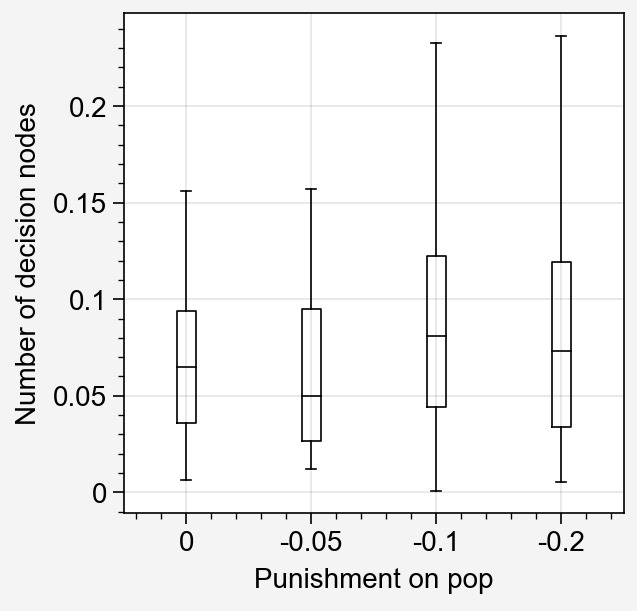

In [10]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')

for i in range(4):
    y = all_decision_nodes[:, i, :, :].reshape(-1)
    ax.boxplot(i, y)
    
ax.format(xlocator=np.arange(4), xformatter=pop_labels, xlabel=pop_axis,
            ylabel='Number of decision nodes',
            title='')

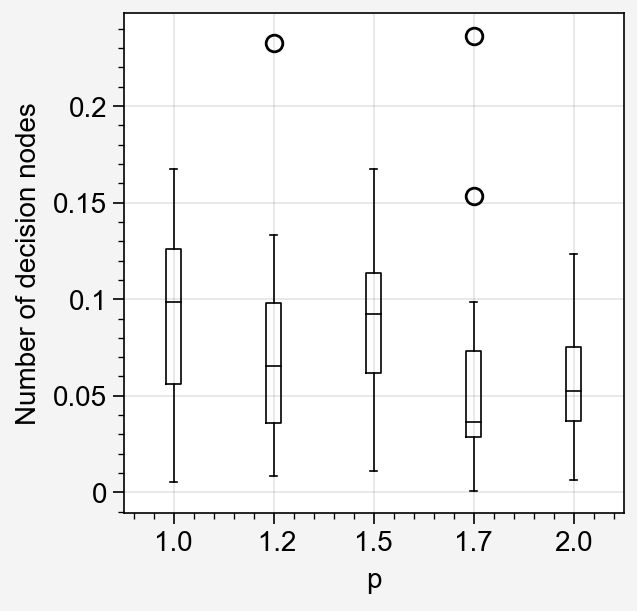

In [12]:
fig, ax = pplt.subplots()
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes, 'first')

ys = []
for j in range(5):
    y = all_decision_nodes[:, :, j, :].reshape(-1)
    ys.append(y)
    ax.boxplot(j, y)
    
ax.format(xlocator=np.arange(5), xformatter=p_labels, xlabel=p_axis,
            ylabel='Number of decision nodes',
            title='')

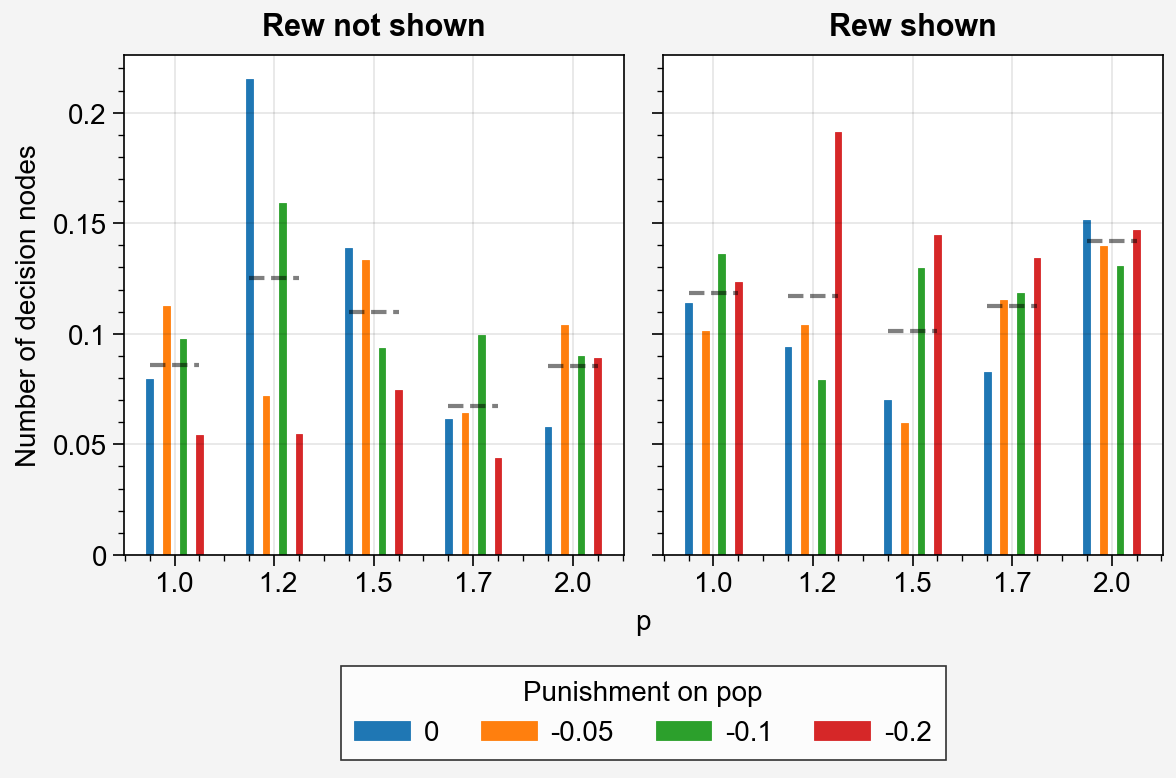

In [42]:
fig, ax = pplt.subplots(ncols=2)
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes)
    
for h in range(2):
    for j in range(len(p_labels)):
        bars = []
        ys = []
        for i in range(len(pop_labels)):
            x = j*6+i
            y = all_decision_nodes[h, i, j, :].mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[i], label=pop_labels[i]))
            ys.append(y)
        y = np.mean(ys)
        ax[h].plot([j*6+0, j*6+3], [y, y], c='black', ls='--', alpha=0.5)
        
fig.legend(bars, loc='b', title=pop_axis, ncols=4)
ax.format(xlocator=np.arange(5)*6+1.5, xformatter=p_labels, xlabel=p_axis,
            ylabel='Number of decision nodes',
            toplabels=give_labels,
            title='')

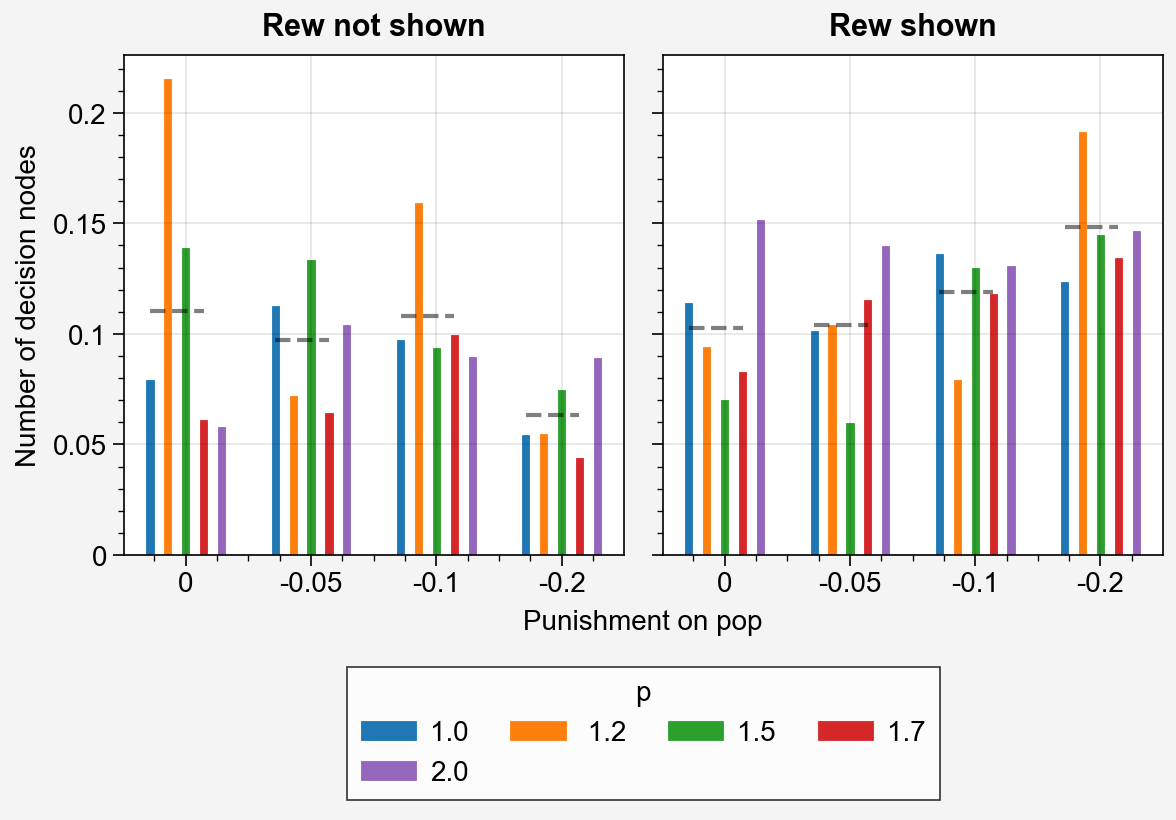

In [47]:
fig, ax = pplt.subplots(ncols=2)
all_decision_nodes = res['all_decision_nodes']
all_decision_nodes = all_decision_nodes.mean(axis=(-2, -1))
all_decision_nodes = select_idxs(all_decision_nodes)
    
for h in range(2):
    for i in range(len(pop_labels)):
        bars = []
        ys = []
        for j in range(len(p_labels)):
            x = i*7+j
            y = all_decision_nodes[h, i, j, :].mean()
            bars.append(ax[h].bar(x, y, c=rgb_colors[j], label=p_labels[j]))
            ys.append(y)
        y = np.mean(ys)
        ax[h].plot([i*7+0, i*7+3], [y, y], c='black', ls='--', alpha=0.5)
        
fig.legend(bars, loc='b', title=p_axis, ncols=4)
ax.format(xlocator=np.arange(5)*7+2, xformatter=pop_labels, xlabel=pop_axis,
            ylabel='Number of decision nodes',
            toplabels=give_labels,
            title='')

# Decision node consistency

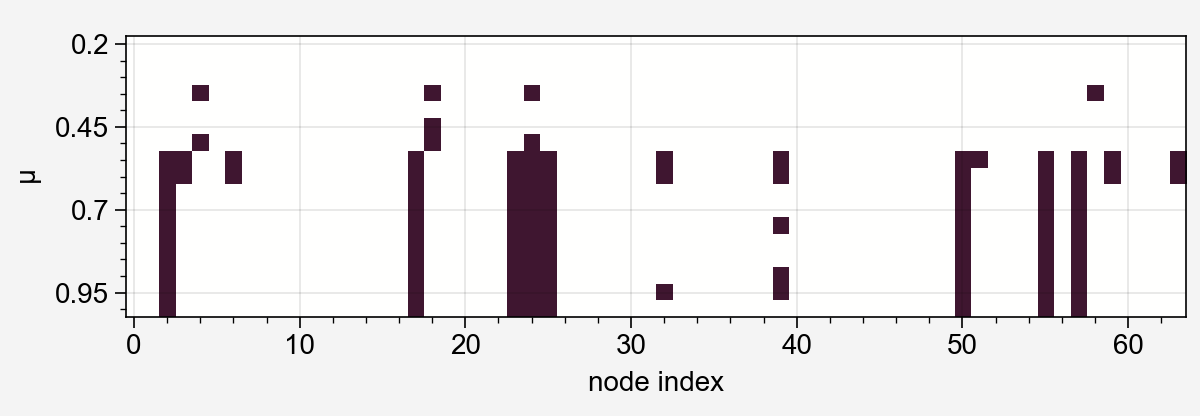

In [331]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/100.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)
all_dec_nodes = np.zeros((17, 64))
for ep in range(17):
    decision_nodes = find_decision_nodes(res, model, ep)
    all_dec_nodes[ep] = decision_nodes*1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)
ax.format(xlabel='node index', ylabel='$\mu$', ylocator=np.arange(0, 16, 5), yrotation=0,
          yformatter=[str(m) for m in np.arange(0, 16, 5)*0.05+0.2])

### Same episode consistency

In [71]:
env_kwargs = [{'meta_setup': 1, 'colors_used': 1, 
                            'max_steps': 2500, 'num_balloons': 40,
                            'inflate_noise': 0,
                            'fix_sizes': [0, 0.5, 0]} for i in range(20)]

evalu = partial(forced_action_evaluate_multi, data_callback=meta_bart_multi_callback,
                env_name="BartMetaEnv", num_episodes=1, 
                env_kwargs=env_kwargs, 
                num_processes=20,
                seed=1,
                deterministic=False,
                with_activations=True)

In [322]:
model, (obs_rms, ret_rms) = \
    torch.load(f'../saved_checkpoints/meta_v2/p1.2n50_0/240.pt')
res = evalu(model, obs_rms)
res = reshape_parallel_evalu_res(res, meta_balloons=40)
# plot_1colornfsize(res)

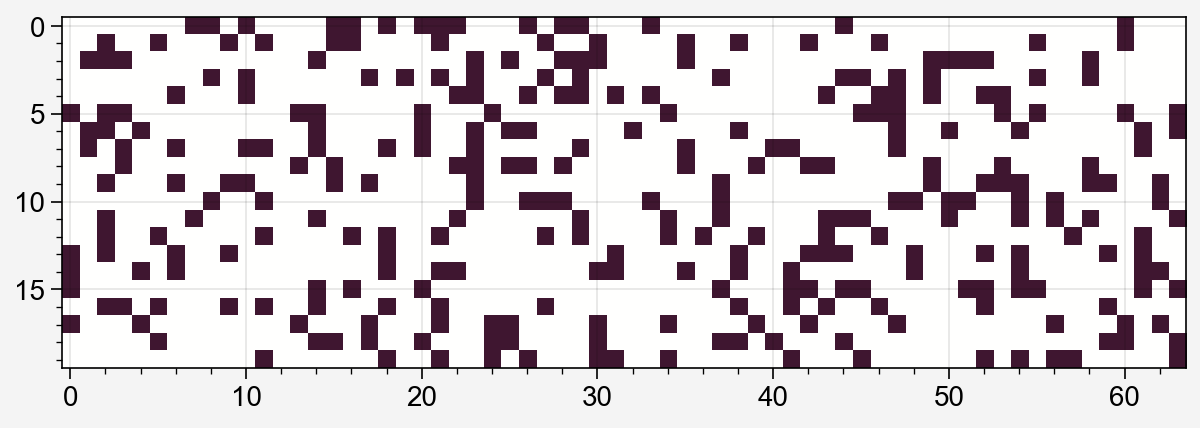

In [99]:
all_dec_nodes = np.zeros((20, 64))
for ep in range(20):
    idxs = np.random.choice(np.arange(64), size=15, replace=False)
    all_dec_nodes[ep, idxs] = 1
fig, ax = pplt.subplots(refaspect=3, figwidth=6)
ax.imshow(all_dec_nodes)